# Exploration of the King County Housing Dataset

My goal in this notebook is to provide plauseable insight into ways a homeowner can make renovations to their current home in order to make it more attactive to buyers and/or sell for a high price.

Let's first import some tools and take our first look at the dataset

In [3]:
#All the imports that we may or may not need
import pandas as pd
pd.set_option('display.max_columns', 50)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
%matplotlib inline
#The data
df = pd.read_csv("data/kc_house_data.csv")
df.head(5)

id        date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  10/13/2014  221900.0         3       1.00         1180   
1  6414100192   12/9/2014  538000.0         3       2.25         2570   
2  5631500400   2/25/2015  180000.0         2       1.00          770   
3  2487200875   12/9/2014  604000.0         4       3.00         1960   
4  1954400510   2/18/2015  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  condition  grade  sqft_above  \
0      5650     1.0         NaN   0.0          3      7        1180   
1      7242     2.0         0.0   0.0          3      7        2170   
2     10000     1.0         0.0   0.0          3      6         770   
3      5000     1.0         0.0   0.0          5      7        1050   
4      8080     1.0         0.0   0.0          3      8        1680   

  sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
0           0.0      1955           0.0    98178  47.5112 -122.257   
1         400.0      1951        1991.0    98125  47.7210 -122.319   
2           0.0      1933           NaN    98028  47.7379 -122.233   
3         910.0      1965           0.0    98136  47.5208 -122.393   
4           0.0      1987           0.0    98074  47.6168 -122.045   

   sqft_living15  sqft_lot15  
0           1340        5650  
1           1690        7639  
2           2720        8062  
3           1360        5000  
4           1800        7503

In [4]:
df.corr().price.sort_values(ascending=False)

price            1.000000
sqft_living      0.701917
grade            0.667951
sqft_above       0.605368
sqft_living15    0.585241
bathrooms        0.525906
view             0.395734
bedrooms         0.308787
lat              0.306692
waterfront       0.276295
floors           0.256804
yr_renovated     0.129599
sqft_lot         0.089876
sqft_lot15       0.082845
yr_built         0.053953
condition        0.036056
long             0.022036
id              -0.016772
zipcode         -0.053402
Name: price, dtype: float64

# Model 1

## 1.a Cleaning and Prepping the data 

Sweet. Now that we can get a good look at what we're working with we will start to clean the data a bit to get it ready for modeling. First, we can already start to eliminate some columns that are irrelevant.
Here's what we can get rid of:

- **id** - the specific id of the house doesn't matter, we just need the data from it to make a model
- **date** - like id, date sold doesn't matter, we just need the data about the house to make a model
- **view** - this is not about the view from the house but how many times it had been view. Not particularly useful
- **zipcode** - this is only helpful if we have information about how safe the neighborhood is. We do not so we will ignore this one
- **lat** - latitude of the house isn't quite as useful as an address
- **long** - like with lat, longitude of a house isn't quite as useful as an address
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors. Not useful
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors. Not useful

In [5]:
# Remove the above mentioned columns
df.drop(['id', 'date', 'view', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15'], axis=1, inplace=True)
# Sanity Check
dfListDrop = list(df.columns)
dfListDrop

['price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated']

Awesome! Now, let's take a look at our data and see if any columns have NaN (missing) values that might get in the way.

In [6]:
df.isna().sum()

price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
dtype: int64

Okay, it looks like we have a couple. Let's take a closer look...

In [7]:
print(df['waterfront'].value_counts())
print('column "waterfront" has', df['waterfront'].isna().sum(), 'NaN values')

0.0    19075
1.0      146
Name: waterfront, dtype: int64
column "waterfront" has 2376 NaN values


In [8]:
print(df['yr_renovated'].value_counts())
print('column "yr_renovated" has', df['yr_renovated'].isna().sum(), 'NaN values')

0.0       17011
2014.0       73
2013.0       31
2003.0       31
2007.0       30
          ...  
1951.0        1
1953.0        1
1946.0        1
1976.0        1
1948.0        1
Name: yr_renovated, Length: 70, dtype: int64
column "yr_renovated" has 3842 NaN values


When it comes to 'waterfront' it looks like the values are 1 or 0 indicating a 'yes' or 'no' as to whether or not it has a waterfront view. Since there isn't much data here to begin with, and we want as many results as posible, we'll simply replace NaN values with a 0 to assume those homes don't have a waterfront view.

In [9]:
# Fill NaN values with 0
df['waterfront'] = df['waterfront'].fillna(0)

In [10]:
# Sanity Check
print(df['waterfront'].value_counts())
print('column "waterfront" has', df['waterfront'].isna().sum(), 'NaN values')

0.0    21451
1.0      146
Name: waterfront, dtype: int64
column "waterfront" has 0 NaN values


As far as 'yr_renovated' the values are either meant to have a year for when it was rennovated or a 0 for if it wasn't renovated. Like the with 'waterfront' we have to assume that NaN values in this case just haven't been renovated at all.

In [11]:
df['yr_renovated'] = df['yr_renovated'].fillna(0)

print(df['yr_renovated'].value_counts())
print('column "yr_renovated" has', df['yr_renovated'].isna().sum(), 'NaN values')

0.0       20853
2014.0       73
2013.0       31
2003.0       31
2007.0       30
          ...  
1951.0        1
1953.0        1
1946.0        1
1976.0        1
1948.0        1
Name: yr_renovated, Length: 70, dtype: int64
column "yr_renovated" has 0 NaN values


Success! Lastly, let's check to make sure all of our columns are either a float or int as our program wont know what to do with anything else

Column 'sqft_basement' is an object. Let's see why...

In [12]:
df.sqft_basement.value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
1920.0        1
3480.0        1
2730.0        1
2720.0        1
248.0         1
Name: sqft_basement, Length: 304, dtype: int64

There is a '?' somewhere in our dataset. That's not a number so it wont convert away from a string to a float or int. And since we can't just *pReTEnD* that the house *dOEsN't* have a basement when it truely might, we can't just zero these values out an ignore it because it would skew our data too much. We're going to have to remove these rows entirely. This shouldn't hit the data too hard since there are plent more rows to spare.

In [13]:
# This code removes all rows that have a '?' value in the basement column
index_names = df[ df['sqft_basement'] == '?' ].index
df.drop(index_names, inplace = True)

# I've already explored this data a bit a know that the rest
# of the data shows up as an object but converts to a float without any fuss
df['sqft_basement'] = df['sqft_basement'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21143 entries, 0 to 21596
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21143 non-null  float64
 1   bedrooms       21143 non-null  int64  
 2   bathrooms      21143 non-null  float64
 3   sqft_living    21143 non-null  int64  
 4   sqft_lot       21143 non-null  int64  
 5   floors         21143 non-null  float64
 6   waterfront     21143 non-null  float64
 7   condition      21143 non-null  int64  
 8   grade          21143 non-null  int64  
 9   sqft_above     21143 non-null  int64  
 10  sqft_basement  21143 non-null  float64
 11  yr_built       21143 non-null  int64  
 12  yr_renovated   21143 non-null  float64
dtypes: float64(6), int64(7)
memory usage: 2.3 MB


Finally, we can start taking a first look at our total dataset and modeling our first substandard model.

## 1.b Buildiing the Model

In [14]:
#creating a column of every feature that is NOT 'price'
xCols = [c for c in df.columns.to_list() if c not in ['price']]

x = df[xCols]
y = df['price']

In [15]:
stdScaled = StandardScaler()

In [16]:
xTrain, xTest, yTrain, yTest = train_test_split(
    x, y, test_size=0.33, random_state=42)

In [17]:
# this is just a sanity check that our test and train
# data equals the whole length of our data frame 
print(len(x))
print(xTrain.shape)
print(xTest.shape)
print(len(xTrain + xTest) == len(x))

21143
(14165, 12)
(6978, 12)
True


In [18]:
xTrainScaled = stdScaled.fit_transform(xTrain)
xTestScaled = stdScaled.transform(xTest)

lr = LinearRegression()
lr.fit(xTrainScaled, yTrain)

yPredTrain = lr.predict(xTrainScaled)
yPredTest = lr.predict(xTestScaled)

print(f"Train Score: {r2_score(yTrain, yPredTrain)}")
print(f"Test Score: {r2_score(yTest, yPredTest)}")
print('-----')
print(f"Train Score: {mean_squared_error(yTrain, yPredTrain, squared=False)}")
print(f"Test Score: {mean_squared_error(yTest, yPredTest, squared=False)}")

Train Score: 0.6470818706483423
Test Score: 0.6452527778610502
-----
Train Score: 218088.3194667647
Test Score: 220372.40946515888


## 1.c Assessing the Damage

Oof. Our model is about $220,000 off and accounts for only 64 percent of our data. Not good. What are we missing? Let's try running this again with different scalers. 

In [19]:
# Model again but with Min Max Scaler
minMaxScaled = MinMaxScaler()

xTrainScaled = minMaxScaled.fit_transform(xTrain)
xTestScaled = minMaxScaled.transform(xTest)

lr = LinearRegression()
lr.fit(xTrainScaled, yTrain)

yPredTrain = lr.predict(xTrainScaled)
yPredTest = lr.predict(xTestScaled)

print(f"Train Score: {r2_score(yTrain, yPredTrain)}")
print(f"Test Score: {r2_score(yTest, yPredTest)}")
print('-----')
print(f"Train Score: {mean_squared_error(yTrain, yPredTrain, squared=False)}")
print(f"Test Score: {mean_squared_error(yTest, yPredTest, squared=False)}")

Train Score: 0.6471066460517836
Test Score: 0.644533300759317
-----
Train Score: 218080.66426222393
Test Score: 220595.76934243916


In [20]:
# Model again but with Robust Scaler
robScaled = RobustScaler()

xTrainScaled = robScaled.fit_transform(xTrain)
xTestScaled = robScaled.transform(xTest)

lr = LinearRegression()
lr.fit(xTrainScaled, yTrain)

yPredTrain = lr.predict(xTrainScaled)
yPredTest = lr.predict(xTestScaled)

print(f"Train R2 Score: {r2_score(yTrain, yPredTrain)}")
print(f"Test R2 Score: {r2_score(yTest, yPredTest)}")
print('-----')
print(f"Dollar Value Variance (Train): {mean_squared_error(yTrain, yPredTrain, squared=False)}")
print(f"Dollar Value Variance (Test): {mean_squared_error(yTest, yPredTest, squared=False)}")

Train R2 Score: 0.6471207231814522
Test R2 Score: 0.6444879405509021
-----
Dollar Value Variance (Train): 218076.31453394078
Dollar Value Variance (Test): 220609.84372816343


No difference at all. Bummer. But also not unexpected.
Let's try something else. How about taking a look at our data in a series of scatter plots for a visual.

Train Score: 0.6465316078832293
-----
Dolar Value Variance: 218827.25787225208


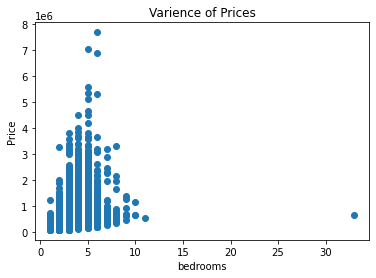

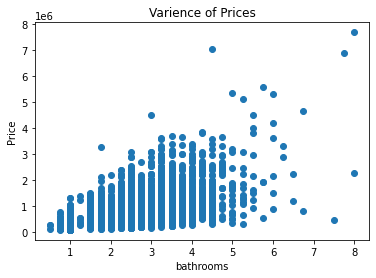

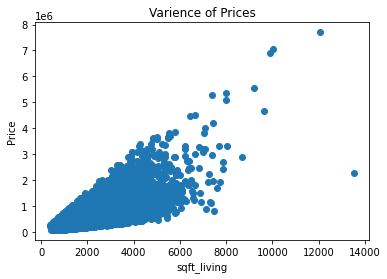

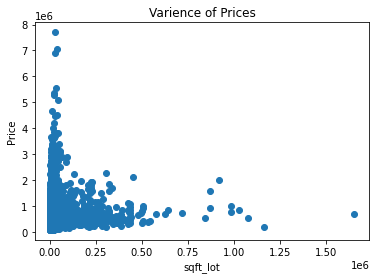

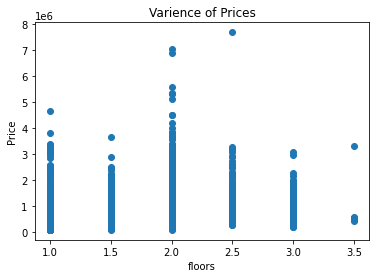

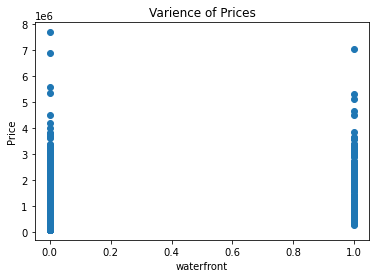

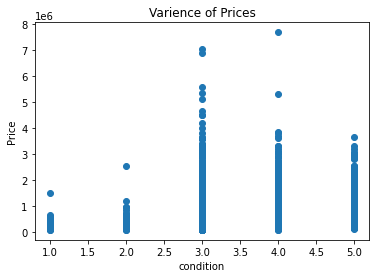

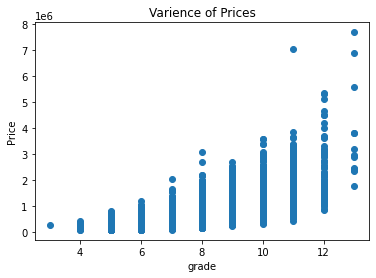

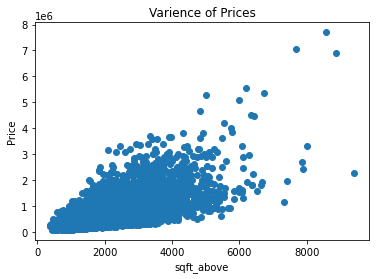

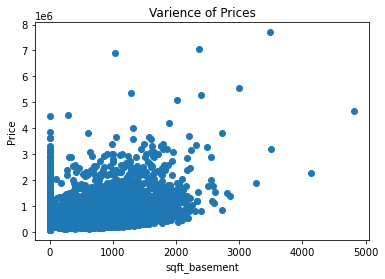

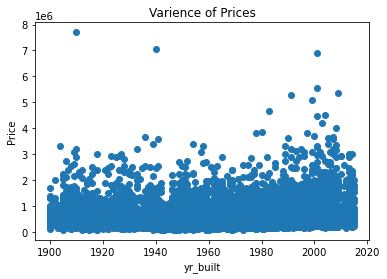

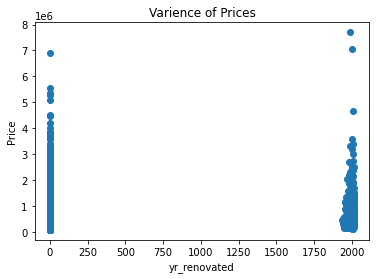

In [21]:
X = df[xCols]
lr = LinearRegression()
lr.fit(X, y)

yPred = lr.predict(X)

print(f"Train Score: {r2_score(y, yPred)}")
print('-----')
print(f"Dolar Value Variance: {mean_squared_error(y, yPred, squared=False)}")

for x in xCols:
    plt.scatter(df[x], df['price'])
    plt.title(f'Plot of Price against {x}')
    plt.xlabel(x)
    plt.ylabel('Price')
    plt.title('Varience of Prices')
    plt.show()

Okay, we're seeing a lot of outliers in out data. Let's check a few more plots and see what else we can see.

In [22]:
trainResiduals = yTrain-yPredTrain
testResiduals = yTest-yPredTest
residuals = y-yPred

(array([1.300e+01, 2.110e+03, 4.683e+03, 1.330e+02, 3.200e+01, 4.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 2.000e+00]),
 array([-1172906.48314674,  -628470.39214103,   -84034.30113533,
          460401.78987038,  1004837.88087608,  1549273.97188179,
         2093710.06288749,  2638146.1538932 ,  3182582.2448989 ,
         3727018.33590461,  4271454.42691031]),
 <BarContainer object of 10 artists>)

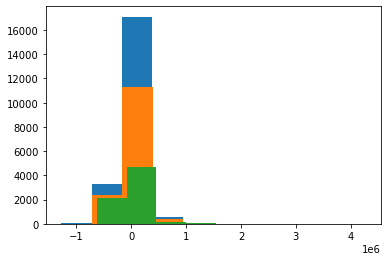

In [23]:
plt.hist(residuals)
plt.hist(trainResiduals)
plt.hist(testResiduals)
# plt.savefig('baselineModelNormalize')

Okay, that's some reasuring info. A LARGE majority of the residual data points we're seeing tends to fall very close to the mean. And those that do exist end to exist on the low end with a few on the exreme high end. So removing the outliers from our data wont take away very many values.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


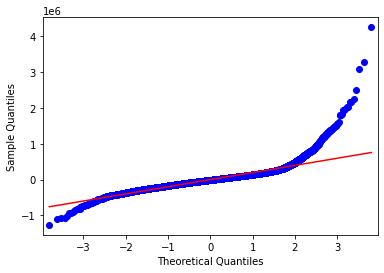

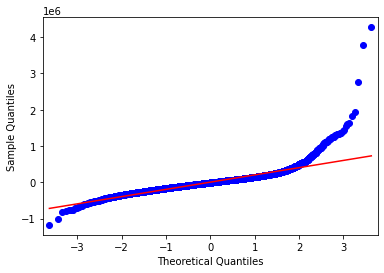

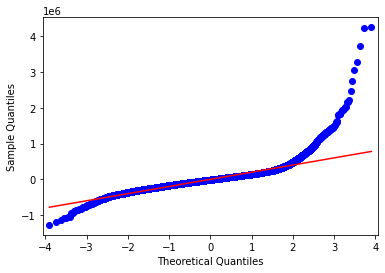

In [24]:
fig = sm.qqplot(trainResiduals, line = 'r')
fig2 = sm.qqplot(testResiduals, line = 'r')
fig3 = sm.qqplot(residuals, line = 'r')

Here we can see the effect those outliers are having. Our trend seems to take a sharp turn up and meters off.

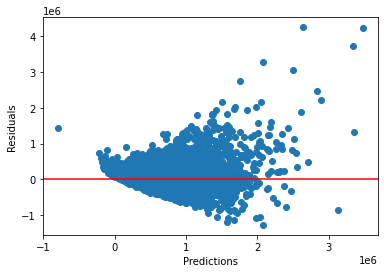

In [25]:
lr = LinearRegression()
lr.fit(X, y)

yPred = lr.predict(X)

plt.scatter(yPred, residuals)
plt.axhline(y=0, color = 'red', label = '0')
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.show()

Ouch. This model shows out predictions seem to be extremely scattered. Good news is that they seem to collect in one spot. Bad news is that the spot is about the size and shape of the Big Island of Hawai'i.

# Model 2

## Cleaning the Data

Okay! Let's try this again but armed with the new knowledge from our assessment of Model 1. Just like last time, we'll impoprt our data so we have a fresh model and clean it again. Why don't we go through some of our models and trim off outliers while we're at at?

In [26]:
# Importing the Data, freshhhhhh
df = pd.read_csv("data/kc_house_data.csv")

# Maximum Effort Data Cleaning 
df.drop(['id', 'date', 'view', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15'], axis=1, inplace=True)
df['waterfront'] = df['waterfront'].fillna(0)
df['yr_renovated'] = df['yr_renovated'].fillna(0)
index_names = df[ df['sqft_basement'] == '?' ].index
df.drop(index_names, inplace = True)
df['sqft_basement'] = df['sqft_basement'].astype(float)

# Data Haircut (used the above plots)
df=df[(df['bedrooms'] < 7)]
df=df[(df['bathrooms'] <= 4) & (df['bathrooms'] != 1.25) & (df['bathrooms'] != 0.5)]
df=df[(df['sqft_living'] < 5000)]
df=df[(df['sqft_lot'] < 20000)]
df=df[(df['floors'] <= 3)]
df=df[(df['condition'] > 2)]
df=df[(df['grade'] > 3) & (df['grade'] < 12) & (df['grade'] != 4)]
df=df[(df['sqft_above'] < 6000)]
df=df[(df['sqft_basement'] < 2000)]
df=df[(df['price'] < 2000000)]


In [27]:
# run the model again
xCols = [c for c in df.columns.to_list() if c not in ['price']]
x = df[xCols]
y = df['price']

xTrain, xTest, yTrain, yTest = train_test_split(
    x, y, test_size=0.33, random_state=42)

xTrainScaled = stdScaled.fit_transform(xTrain)
xTestScaled = stdScaled.transform(xTest)

lr = LinearRegression()
lr.fit(xTrainScaled, yTrain)

yPredTrain = lr.predict(xTrainScaled)
yPredTest = lr.predict(xTestScaled)

print(f"Train Score: {r2_score(yTrain, yPredTrain)}")
print(f"Test Score: {r2_score(yTest, yPredTest)}")
print('-----')
print(f"Train Score: {mean_squared_error(yTrain, yPredTrain, squared=False)}")
print(f"Test Score: {mean_squared_error(yTest, yPredTest, squared=False)}")

Train Score: 0.6093741854702279
Test Score: 0.6033847524768017
-----
Train Score: 164841.6339488892
Test Score: 169652.60485457288


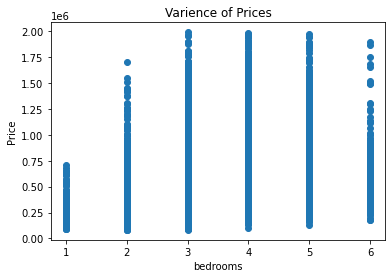

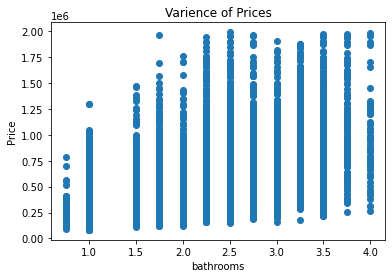

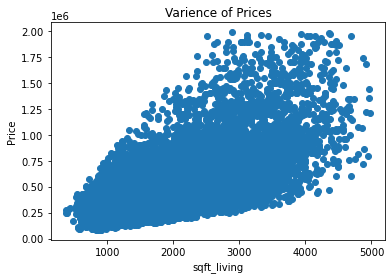

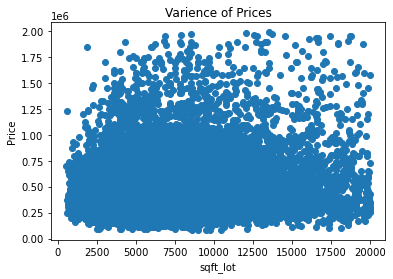

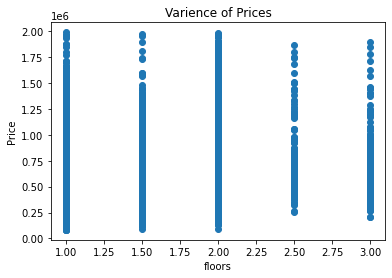

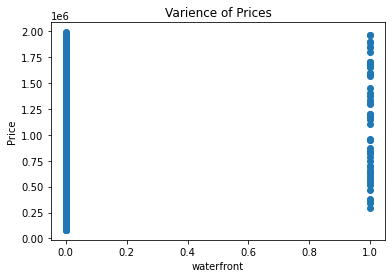

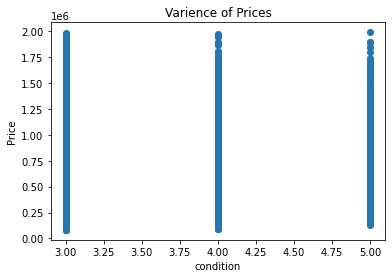

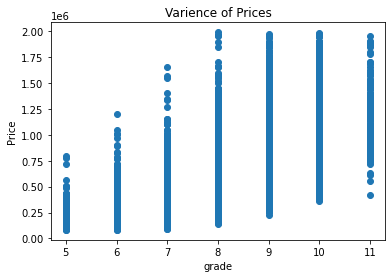

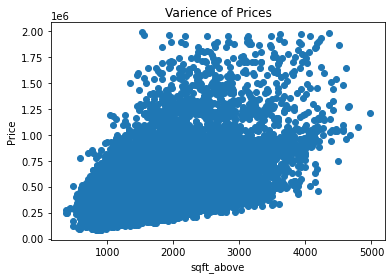

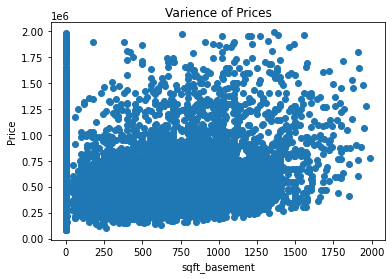

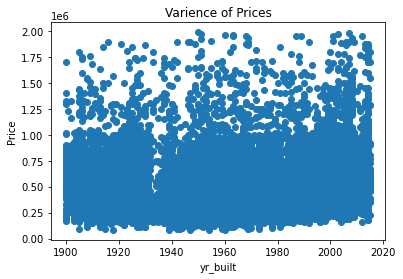

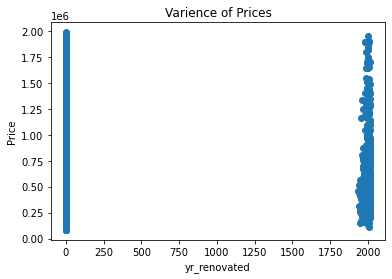

In [28]:
# Run the plots, again
for x in xCols:
    plt.scatter(df[x], df['price'])
    plt.title(f'Plot of Price against {x}')
    plt.xlabel(x)
    plt.ylabel('Price')
    plt.title('Varience of Prices')
    plt.show()

(array([  27.,  358., 2024., 2673.,  727.,  125.,   69.,   28.,   11.,
           4.]),
 array([-579076.66786306, -401995.29559031, -224913.92331757,
         -47832.55104482,  129248.82122793,  306330.19350067,
         483411.56577342,  660492.93804616,  837574.31031891,
        1014655.68259166, 1191737.0548644 ]),
 <BarContainer object of 10 artists>)

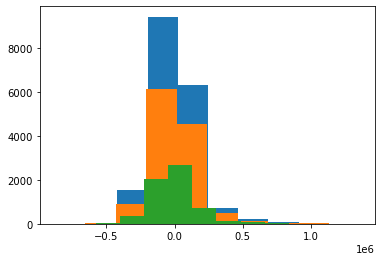

In [29]:
X = df[xCols]
lr = LinearRegression()
lr.fit(X, y)

yPred = lr.predict(X)

trainResiduals = yTrain-yPredTrain
testResiduals = yTest-yPredTest
residuals = y-yPred

plt.hist(residuals)
plt.hist(trainResiduals)
plt.hist(testResiduals)
# plt.savefig('Model2Normalize')

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


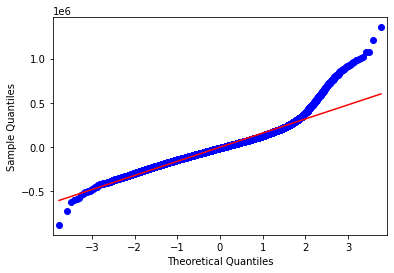

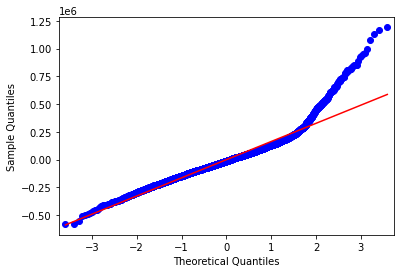

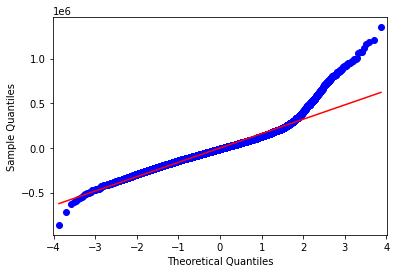

In [30]:
fig = sm.qqplot(trainResiduals, line = 'r')
fig2 = sm.qqplot(testResiduals, line = 'r')
fig3 = sm.qqplot(residuals, line = 'r')

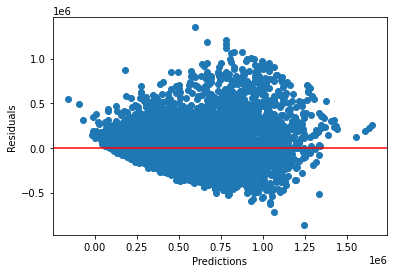

In [31]:
plt.scatter(yPred, residuals)
plt.axhline(y=0, color = 'red', label = '0')
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.show()

Alright, after fiddling with the data for a long while I've somehow made the model worse. Let's take a step back and reevaluate. Perhaps there's some useful data in what we removed earlier. Let's add some of it back in and see how Our results change purely on that.

# Model 3

Train R2 Score: 0.6961840815077176
Test R2 Score: 0.7101463584756225
-----
Dollar Value Variance (Train): 204582.10359046079
Dollar Value Variance (Test): 202821.66803727273


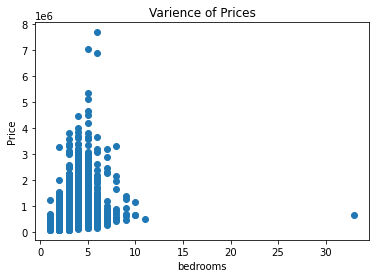

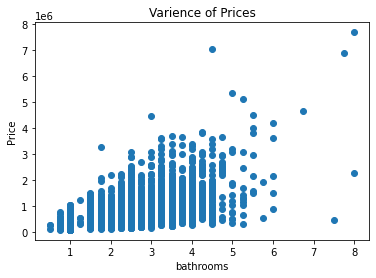

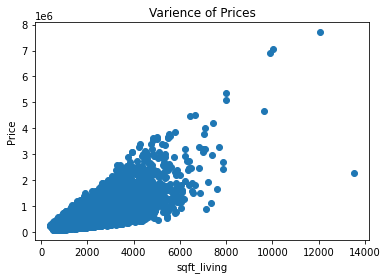

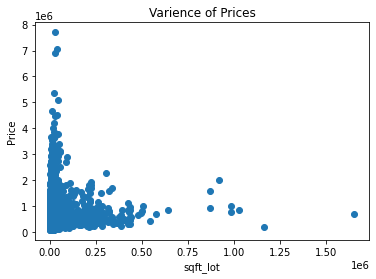

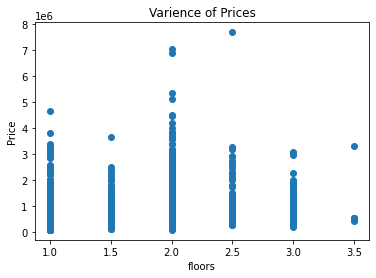

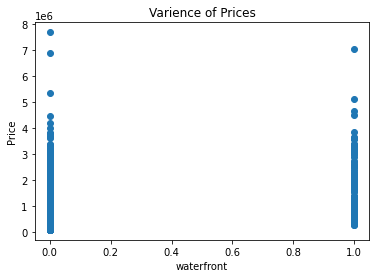

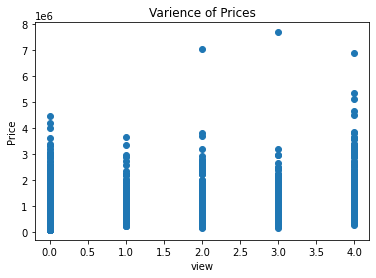

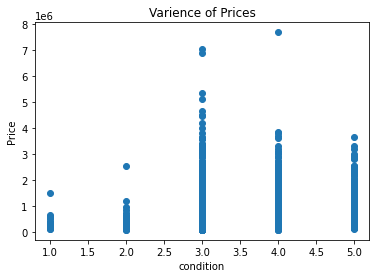

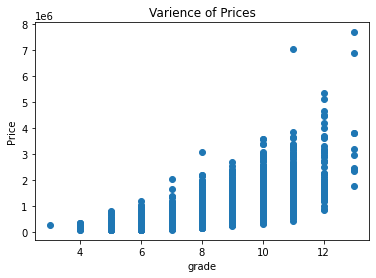

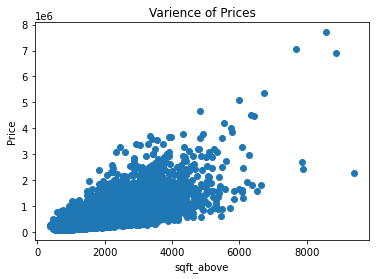

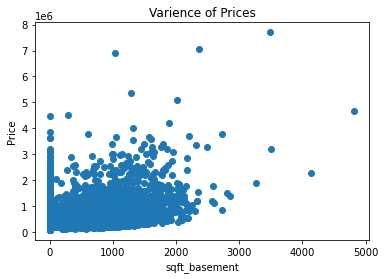

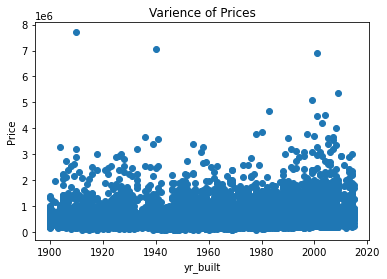

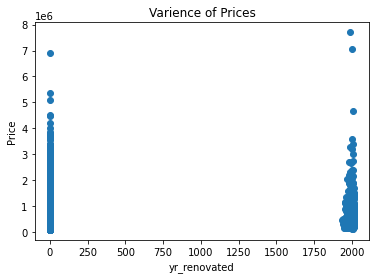

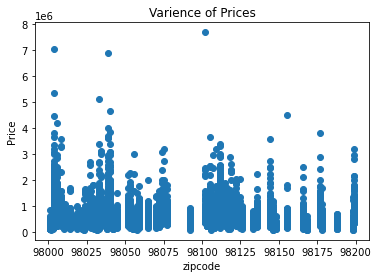

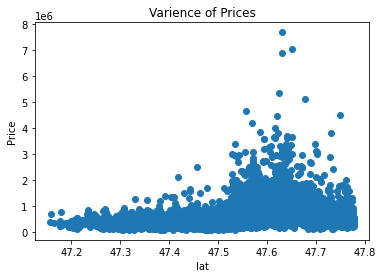

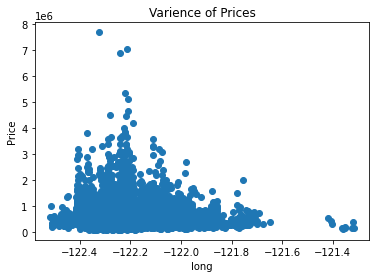

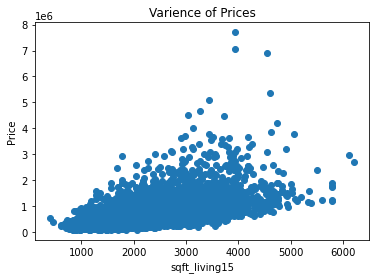

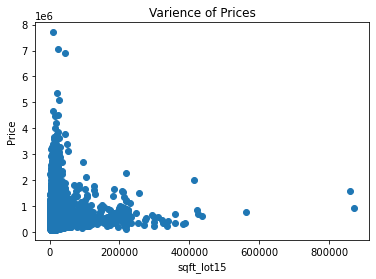

In [32]:
df = pd.read_csv("data/kc_house_data.csv")
# Changes to the list of dropped columns
# Only removed 2 columns ('id' & 'date') this time.
df.drop(['id', 'date'], axis=1, inplace=True)
df = df.dropna()
index_names = df[ df['sqft_basement'] == '?' ].index
df.drop(index_names, inplace = True)
df['sqft_basement'] = df['sqft_basement'].astype(float)
      
xCols = [c for c in df.columns.to_list() if c not in ['price']]
x = df[xCols]
y = df['price']

xTrain, xTest, yTrain, yTest = train_test_split(
    x, y, test_size=0.33, random_state=42)

xTrainScaled = stdScaled.fit_transform(xTrain)
xTestScaled = stdScaled.transform(xTest)

lr = LinearRegression()
lr.fit(xTrainScaled, yTrain)

yPredTrain = lr.predict(xTrainScaled)
yPredTest = lr.predict(xTestScaled)

print(f"Train R2 Score: {r2_score(yTrain, yPredTrain)}")
print(f"Test R2 Score: {r2_score(yTest, yPredTest)}")
print('-----')
print(f"Dollar Value Variance (Train): {mean_squared_error(yTrain, yPredTrain, squared=False)}")
print(f"Dollar Value Variance (Test): {mean_squared_error(yTest, yPredTest, squared=False)}")

for x in xCols:
    plt.scatter(df[x], df['price'])
    plt.title(f'Plot of Price against {x}')
    plt.xlabel(x)
    plt.ylabel('Price')
    plt.title('Varience of Prices')
    plt.show()

Oo! Oo! Oo! Progress! We're seeing pregress. We've jumped from 64 to 70 percent and a small decrease in the Dollar Varience. Still not great but we're making progress in thr right direction. Let's check out plots.

(array([1.300e+01, 1.508e+03, 3.476e+03, 7.400e+01, 1.600e+01, 4.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([-1171491.51630518,  -625859.54764293,   -80227.57898067,
          465404.38968158,  1011036.35834384,  1556668.32700609,
         2102300.29566835,  2647932.2643306 ,  3193564.23299285,
         3739196.20165511,  4284828.17031736]),
 <BarContainer object of 10 artists>)

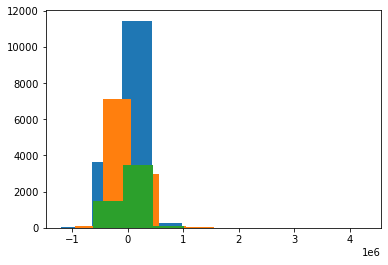

In [33]:
xCols = [c for c in df.columns.to_list() if c not in ['price']]
x = df[xCols]
y = df['price']

trainResiduals = yTrain-yPredTrain
testResiduals = yTest-yPredTest
lr = LinearRegression()
lr.fit(x, y)

yPred = lr.predict(x)
residuals = y-yPred

plt.hist(residuals)
plt.hist(trainResiduals)
plt.hist(testResiduals)
# plt.savefig('Model3Normalize')

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


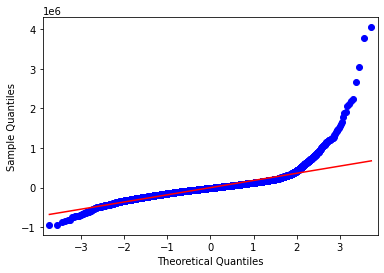

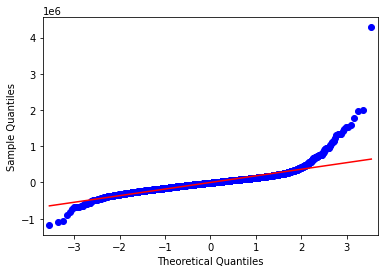

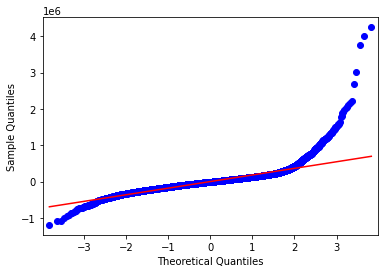

In [34]:
fig = sm.qqplot(trainResiduals, line = 'r')
fig2 = sm.qqplot(testResiduals, line = 'r')
fig3 = sm.qqplot(residuals, line = 'r')

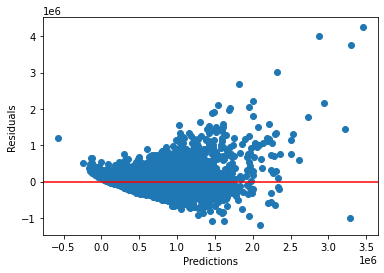

In [35]:
plt.scatter(yPred, residuals)
plt.axhline(y=0, color = 'red', label = '0')
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.show()

Nothing has really changed, but that was expected. We haven't trimmed the data on this one. Let's do that and see if we can't make more improvements. Practically just a combination of Models 2 & 3.

# Model 4

Train R2 Score: 0.6936703591900614
Test R2 Score: 0.6756440070126208
-----
Dollar Value Variance (Train): 114395.19879776801
Dollar Value Variance (Test): 117124.95926191621


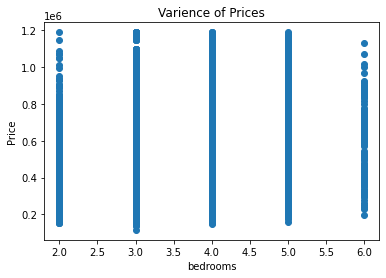

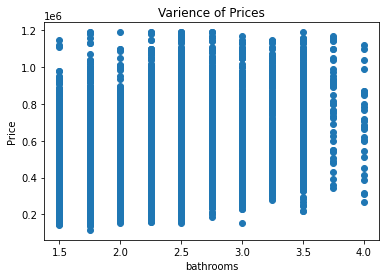

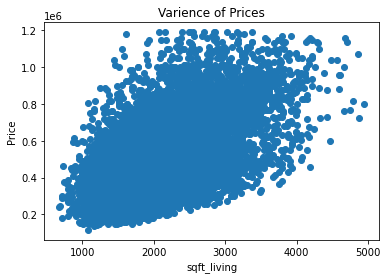

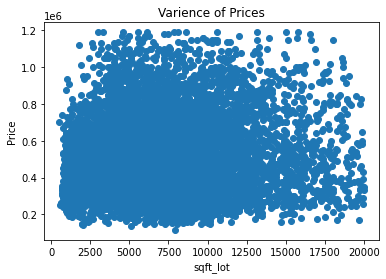

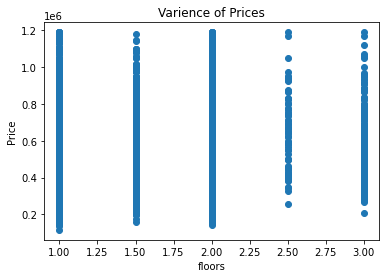

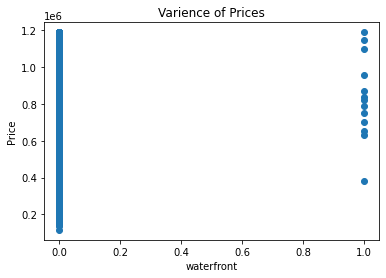

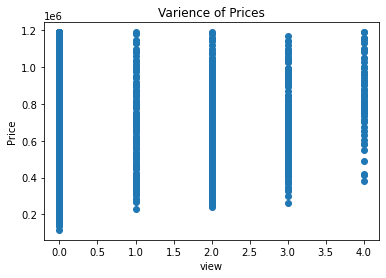

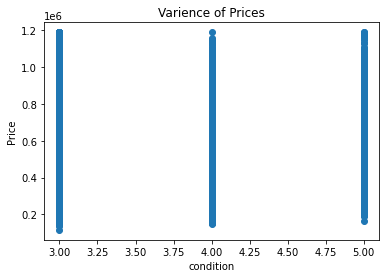

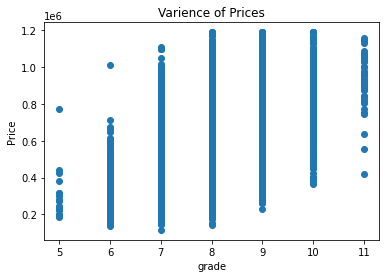

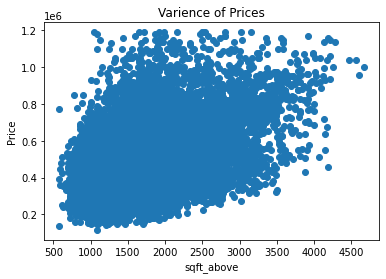

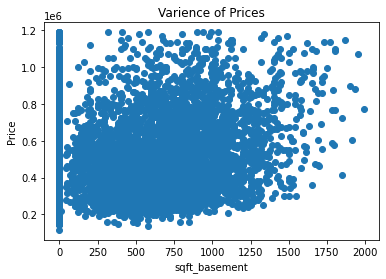

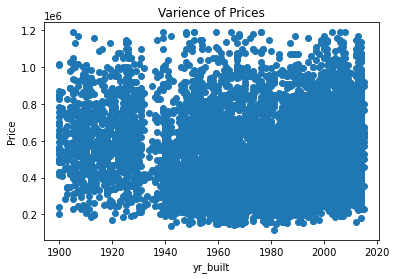

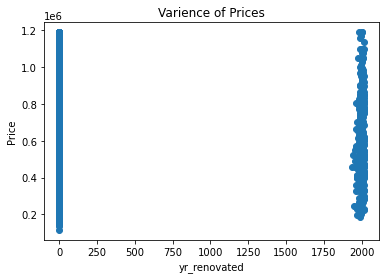

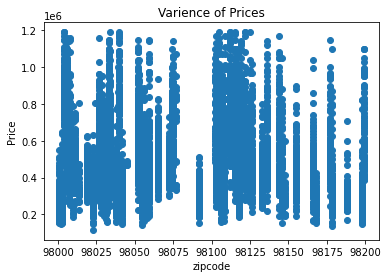

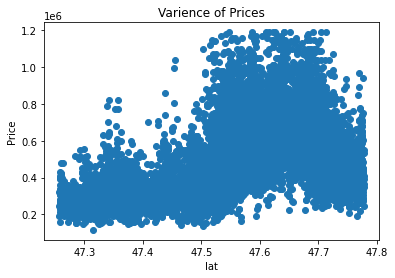

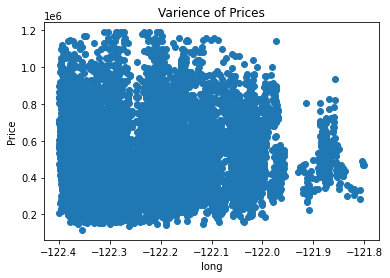

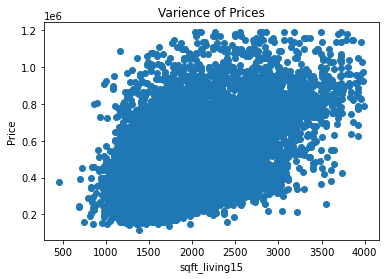

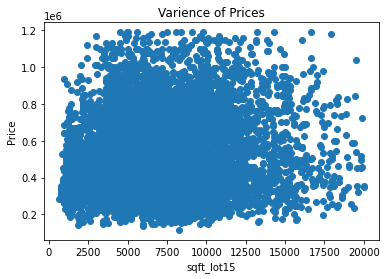

In [36]:
df = pd.read_csv("data/kc_house_data.csv")
# Keeping column list from model 3
df.drop(['id', 'date'], axis=1, inplace=True)
df = df.dropna()
index_names = df[ df['sqft_basement'] == '?' ].index
df.drop(index_names, inplace = True)
df['sqft_basement'] = df['sqft_basement'].astype(float)

# Cleaing from model 2 (but edited a bit)
df=df[(df['bedrooms'] < 7) & (df['bedrooms'] != 1)]
df=df[(df['bathrooms'] <= 4) & (df['bathrooms'] != 1.25) & (df['bathrooms'] > 1)]
df=df[(df['sqft_living'] < 5000)]
df=df[(df['sqft_lot'] < 20000)]
df=df[(df['floors'] <= 3)]
df=df[(df['condition'] > 2)]
df=df[(df['grade'] > 3) & (df['grade'] < 12) & (df['grade'] != 4)]
df=df[(df['sqft_above'] < 6000)]
df=df[(df['sqft_basement'] < 2000)]
df=df[(df['price'] < 1200000) & (df['price'] > 100000)] 

# New data cleaning for new columns
df=df[(df['long'] < -121.8) & (df['long'] > -122.4)]
df=df[(df['lat'] > 47.25)]
df=df[(df['sqft_living15'] < 4000)]
df=df[(df['sqft_lot15'] < 20000)]

xCols = [c for c in df.columns.to_list() if c not in ['price']]
x = df[xCols]
y = df['price']

xTrain, xTest, yTrain, yTest = train_test_split(
    x, y, test_size=0.33, random_state=42)

xTrainScaled = stdScaled.fit_transform(xTrain)
xTestScaled = stdScaled.transform(xTest)

lr = LinearRegression()
lr.fit(xTrainScaled, yTrain)

yPredTrain = lr.predict(xTrainScaled)
yPredTest = lr.predict(xTestScaled)

print(f"Train R2 Score: {r2_score(yTrain, yPredTrain)}")
print(f"Test R2 Score: {r2_score(yTest, yPredTest)}")
print('-----')
print(f"Dollar Value Variance (Train): {mean_squared_error(yTrain, yPredTrain, squared=False)}")
print(f"Dollar Value Variance (Test): {mean_squared_error(yTest, yPredTest, squared=False)}")

for x in xCols:
    plt.scatter(df[x], df['price'])
    plt.title(f'Plot of Price against {x}')
    plt.xlabel(x)
    plt.ylabel('Price')
    plt.title('Varience of Prices')
    plt.show()

(array([   3.,   11.,   96.,  629., 1430.,  809.,  232.,   72.,   18.,
           5.]),
 array([-533404.25061629, -420541.7521916 , -307679.25376691,
        -194816.75534223,  -81954.25691754,   30908.24150715,
         143770.73993184,  256633.23835652,  369495.73678121,
         482358.2352059 ,  595220.73363059]),
 <BarContainer object of 10 artists>)

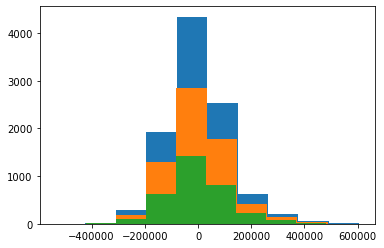

In [37]:
xCols = [c for c in df.columns.to_list() if c not in ['price']]
x = df[xCols]
y = df['price']

trainResiduals = yTrain-yPredTrain
testResiduals = yTest-yPredTest
lr = LinearRegression()
lr.fit(x, y)

yPred = lr.predict(x)
residuals = y-yPred

plt.hist(residuals)
plt.hist(trainResiduals)
plt.hist(testResiduals)
# plt.savefig('Model4Normalize')

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


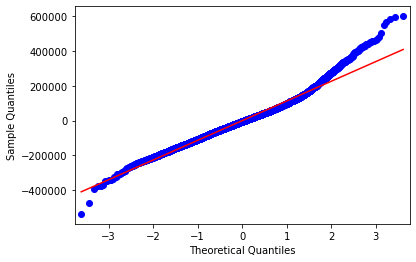

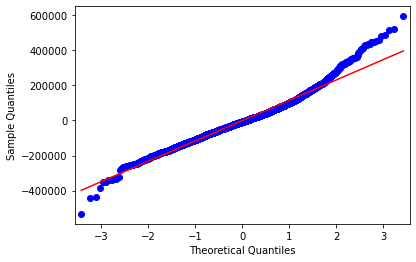

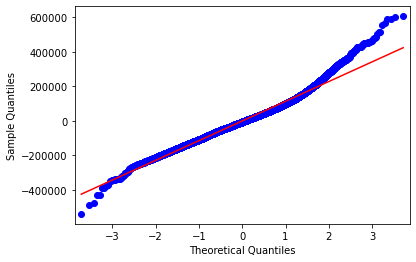

In [38]:
fig = sm.qqplot(trainResiduals, line = 'r')
fig2 = sm.qqplot(testResiduals, line = 'r')
fig3 = sm.qqplot(residuals, line = 'r')

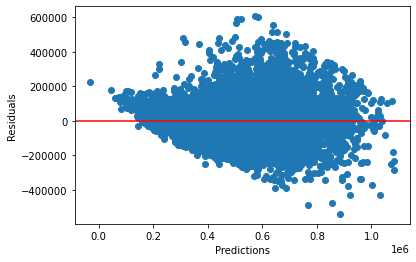

In [39]:
plt.scatter(yPred, residuals)
plt.axhline(y=0, color = 'red', label = '0')
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.show()


This is good. Not amazing but better than what we had. We now have about a 30% variance on our predictions and parameters on what kinda of housing fits within that prediction. Homes that have 
- between 2 and 7 bedrooms
- between 1 and 4 bathrooms but NOT 1.25 bathrooms
- a living space of less than 5,000 sqare feet
- a lot of less than 20,000 square feet
- 3 or less floors
- weather or not it has a waterfront view
- how many people have viewed it in an open house
- a condition rating of greater than 2
- a grade rating between 3 and 12 but NOT 4
- a second floor of less than 6,000 square feet
- a basement of less than 2,000 square feet
- year it was built
- year it was renovated
- zipcode
- a longitude aproximately between -121.8 and -122.4
- a latitude aproximately between 47.3 amd 47.8
- nearest 15 neighbors with a living space of less than 4000
- nearest 15 neighbors with a lot space of less than 4000

can predict within a range of 100,000 dollars to 1,200,000 dollars.

In [40]:
df.describe()

price      bedrooms     bathrooms   sqft_living      sqft_lot  \
count  1.001500e+04  10015.000000  10015.000000  10015.000000  10015.000000   
mean   4.976459e+05      3.484873      2.279406   2092.746580   7311.090764   
std    2.063680e+05      0.786181      0.503021    652.129974   3687.378191   
min    1.150000e+05      2.000000      1.500000    680.000000    520.000000   
25%    3.350000e+05      3.000000      1.750000   1600.000000   4782.500000   
50%    4.550000e+05      3.000000      2.250000   2000.000000   7205.000000   
75%    6.250000e+05      4.000000      2.500000   2492.500000   9417.000000   
max    1.190000e+06      6.000000      4.000000   4940.000000  19998.000000   

             floors    waterfront          view     condition         grade  \
count  10015.000000  10015.000000  10015.000000  10015.000000  10015.000000   
mean       1.565352      0.001298      0.157863      3.403595      7.701048   
std        0.554587      0.036007      0.611244      0.633802      0.909799   
min        1.000000      0.000000      0.000000      3.000000      5.000000   
25%        1.000000      0.000000      0.000000      3.000000      7.000000   
50%        1.500000      0.000000      0.000000      3.000000      8.000000   
75%        2.000000      0.000000      0.000000      4.000000      8.000000   
max        3.000000      1.000000      4.000000      5.000000     11.000000   

         sqft_above  sqft_basement      yr_built  yr_renovated       zipcode  \
count  10015.000000   10015.000000  10015.000000  10015.000000  10015.000000   
mean    1788.174838     304.571742   1976.818972     69.049825  98074.715926   
std      664.752098     415.197460     28.096105    365.046943     52.344943   
min      580.000000       0.000000   1900.000000      0.000000  98001.000000   
25%     1290.000000       0.000000   1960.000000      0.000000  98031.000000   
50%     1630.000000       0.000000   1980.000000      0.000000  98059.000000   
75%     2170.000000     610.000000   2002.000000      0.000000  98117.000000   
max     4670.000000    1990.000000   2015.000000   2015.000000  98199.000000   

                lat          long  sqft_living15    sqft_lot15  
count  10015.000000  10015.000000   10015.000000  10015.000000  
mean      47.559788   -122.216286    1977.089865   7150.703744  
std        0.137576      0.125967     563.646756   3280.937414  
min       47.257400   -122.399000     460.000000    659.000000  
25%       47.461000   -122.322000    1560.000000   4853.000000  
50%       47.571800   -122.221000    1880.000000   7260.000000  
75%       47.679300   -122.135000    2310.000000   9011.500000  
max       47.777600   -121.801000    3990.000000  19998.000000

In [41]:
lrOrder = dict(zip(X.columns, lr.coef_))
dict(sorted(lrOrder.items(), key=lambda item: item[1]))

{'bedrooms': -8845.257383758173,
 'yr_renovated': -1891.7698579773369,
 'sqft_lot': -2.918798862328913,
 'yr_built': 26.22654760920318,
 'sqft_basement': 31.671900340260436,
 'sqft_living': 57.89844794403052,
 'floors': 11648.770485617395,
 'bathrooms': 22484.904777409818,
 'grade': 32501.969588147764,
 'condition': 32878.99011221063,
 'sqft_above': 81729.92392670961,
 'waterfront': 225844.8818731459}

Here, I can see which features of my model have the highest impact on the model overall. So now, not only do I have a range for what houses can I apply to this model but I can make recommendations to a home owner to make thier house more valueable and attractive on a market. Here are the qualities of a house that can be modified to be better. These will be ordered from least to greatest impact on the value of a home.

- **Grade** - Grade of a house is based on the plot of land around it and how level it is. Doing some landscapping can help imporve the grade.
- **Condition** - A lot of things affect the condition of a home but some of the things within a home owner's control would be useable space and the qiality of the home itself. Typically people want a 'Move-in Ready" home so fixing small things like loose sockets, retiling broken roofs, replacing and fixing the property fence and knocking down unnecessary walls to increase usable space can increase the condition
- **Living Squarefootage** - Increasing the squarefootage of the houses footprint is the biggest contributing factor to a home. Adding things like a deck, an extra room, a garage/extending a garage, a sun room. All of these things can be expensive but could prtentially return more than what is spent.
- **Additional Bathroom & Bedrooms** - This goes back into the above topic, adding an extra bedroom/bathroom as attractive as well as the extra sqaurefootage it'll garner.